# Building workflows with the IBM Circuit function
*Usage estimate: 26 minutes on IBM Brisbane (NOTE: This is an estimate only. Your runtime may vary.)*

In this notebook, we will walk through an example of building and running a workflow using the IBM Circuit function. This function takes [Primitive Unified Blocs](https://docs.quantum.ibm.com/guides/primitive-input-output) (PUBs) as inputs and returns error-mitigated expectation values as outputs. It provides an automated and customized pipeline to optimize circuits and execute on quantum hardware so that researchers can focus on algorithm and application discovery.

Visit the documentation for an [introduction to Qiskit Functions](https://docs.quantum.ibm.com/guides/functions) and learn how to get started with the [IBM Circuit function](https://docs.quantum.ibm.com/guides/ibm-circuit-function).

## Background

For this tutorial, we consider a general hardware-efficient Trotterized time evolution circuit for the 2D tranverse-field Ising model and compute the global magnetization. Such a circuit is useful in different application domains such as condensed matter physics, chemistry, machine learning etc. For more information on the structure of this model, refer to [Nature 618, 500–505 (2023)](https://www.nature.com/articles/s41586-023-06096-3).

The IBM Circuit function combines capabilities from the Qiskit transpiler service and Qiskit Runtime Estimator to provide a simplified interface for running circuits. The function performs transpilation, error suppresion, error mitigation, and circuit execution within a single managed service so that we can focus on mapping the problem to circuits rather than building out each step of the pattern ourselves.

## Requirements

Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK 1.2 or later (`pip install qiskit`)
- Qiskit Runtime 0.28 or later (`pip install qiskit-ibm-runtime`)
- IBM Qiskit Functions Catalog client 0.0.0 or later (`pip install qiskit-ibm-catalog`)
- Qiskit Aer 0.15.0 or later (`pip install qiskit-aer`)

## Setup

In [ ]:
import rustworkx
from collections import defaultdict
from numpy import pi, mean

from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ibm_catalog import QiskitFunctionsCatalog

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp

## Step 1: Map classical inputs to a quantum problem

<ul>
    <li>Input: Parameters to create the quantum circuit</li>
    <li>Output: Abstract circuit and observables</li>
</ul>

#### Construct the circuit

The circuit we will create is a hardware-efficient, Trotterized time evolution circuit for the 2D transverse-field Ising model. We start with selecting a backend. Properties of this backend (i.e., its coupling map) will be used to define the quantum problem and ensure it is hardware-efficient.

In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

Next, we get the coupling map from the backend.

In [ ]:
coupling_graph = backend.coupling_map.graph.to_undirected(multigraph=False)
layer_couplings = defaultdict(list)

We want to be careful in how we design the layers of our circuit. We will do this by coloring the edges of the coupling map (i.e., grouping the disjoint edges) and use that coloring to more efficiently place gates in the circuit. This will lead to a shallower circuit with layers of gates that can be executed simultaneously on the hardware.

In [3]:
edge_coloring = rustworkx.graph_bipartite_edge_color(coupling_graph)

for edge_idx, color in edge_coloring.items():
    layer_couplings[color].append(
        coupling_graph.get_edge_endpoints_by_index(edge_idx)
    )
layer_couplings = [
    sorted(layer_couplings[i]) for i in sorted(layer_couplings.keys())
]

Next, we write a simple helper function that implements the hardware-efficient, Trotterized time evolution circuit for the 2D transverse-field Ising model using the edge coloring obtained above.

In [ ]:
def construct_trotter_circuit(
    num_qubits: int,
    num_trotter_steps: int,
    layer_couplings: list,
    barrier: bool = True,
) -> QuantumCircuit:
    theta, phi = Parameter("theta"), Parameter("phi")
    circuit = QuantumCircuit(num_qubits)

    for _ in range(num_trotter_steps):
        circuit.rx(theta, range(num_qubits))
        for layer in layer_couplings:
            for edge in layer:
                if edge[0] < num_qubits and edge[1] < num_qubits:
                    circuit.rzz(phi, edge[0], edge[1])
        if barrier:
            circuit.barrier()

    return circuit

We will choose the number of qubits and trotter steps and then construct the circuit.

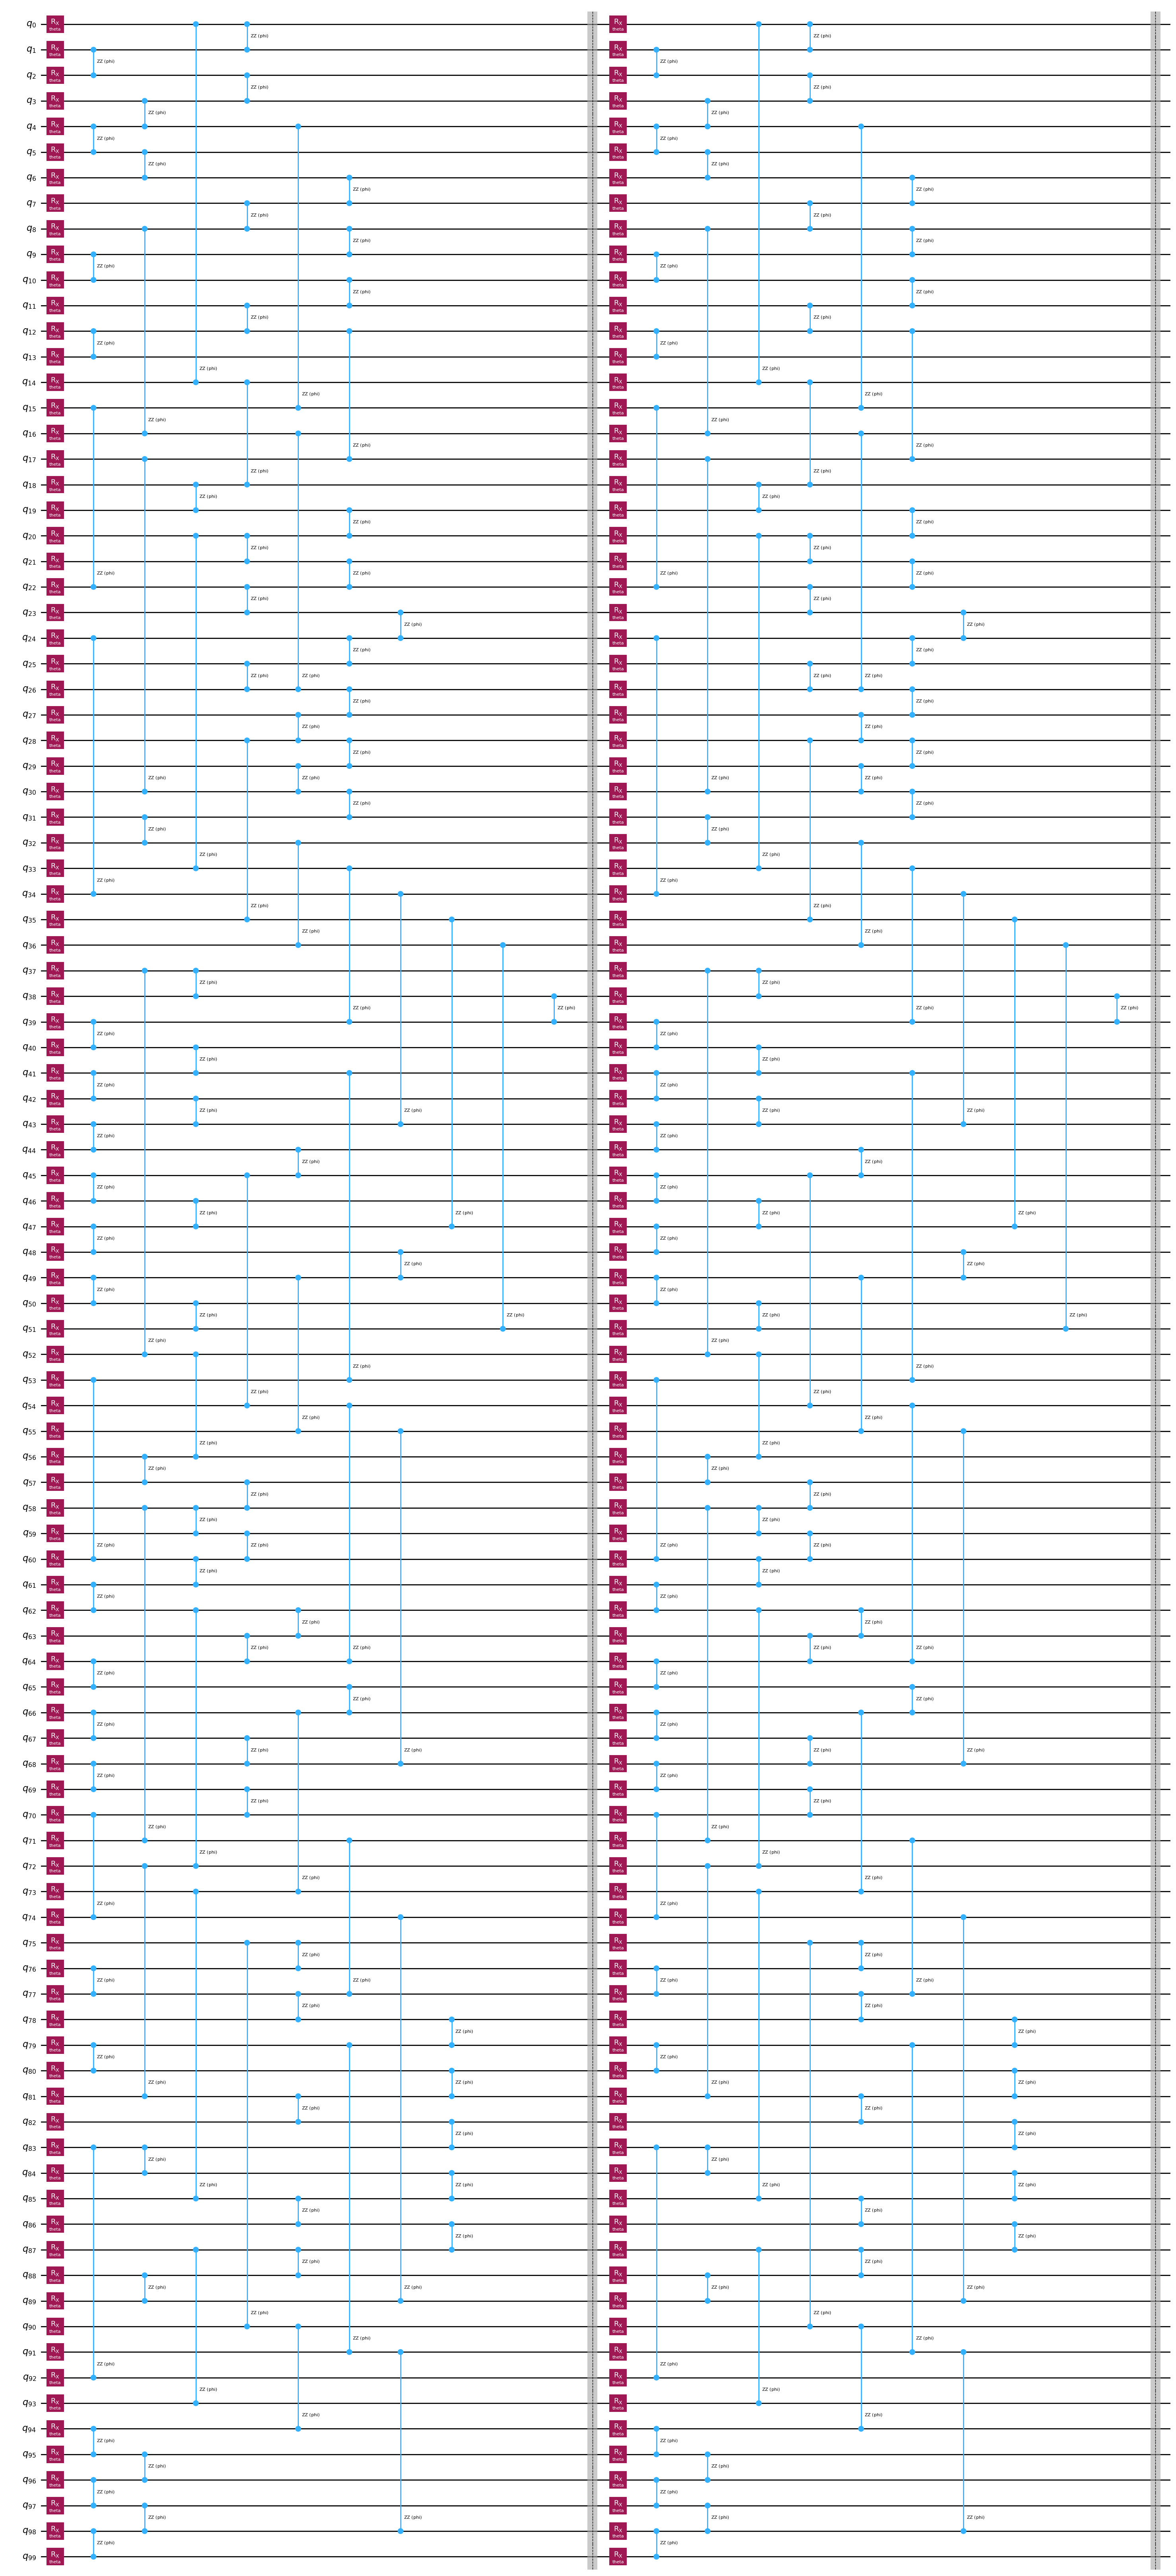

In [5]:
num_qubits = 100
num_trotter_steps = 2

circuit = construct_trotter_circuit(
    num_qubits, num_trotter_steps, layer_couplings
)
circuit.draw("mpl", fold=-1)

In order to benchmark the quality of the execution, we need to compare it with the ideal outcome. The circuit of choice is beyond brute force classical simulation. So, we fix the parameters of all the `Rx` gates in the circuit to $0$, and that of all `Rzz` gates to $\pi$. This makes the circuit Clifford, which makes it possible to perform the ideal simulation and obtain the ideal outcome for comparison. In this case, we know that outcome will be `1.0`.

In [ ]:
parameters = [0, pi]

#### Construct the observable

In this tutorial, we will compute the global magnetization along $\hat{z}$ for our $N$-qubit problem: $M_z = \sum_{i=1}^N \langle Z_i \rangle / N$. This requires first computing the single-site magnetization $\langle Z_i \rangle$ for each qubit $i$, which we define below.

In [ ]:
observables = []
for i in range(num_qubits):
    obs = "I" * (i) + "Z" + "I" * (num_qubits - i - 1)
    observables.append(SparsePauliOp(obs))

print(observables[0])

SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])


## Steps 2 and 3: Optimize problem for quantum hardware execution and execute with the IBM Circuit function

<ul>
    <li>Input: Abstract circuit and observables</li>
    <li>Output: Mitigated expectation values</li>
</ul>

Now, we can pass the abstract circuit and observables to the IBM Circuit function. It will handle transpilation and execution on quantum hardware for us and return mitigated expectation values. First, we load the function from the [IBM Qiskit Functions Catalog](https://docs.quantum.ibm.com/guides/functions).

In [ ]:
catalog = QiskitFunctionsCatalog(token="<YOUR_IQP_API_TOKEN>")
function = catalog.load("ibm/circuit-function")

The IBM Circuit function takes `pubs`, `backend_name`, as well as optional inputs for configuring transpilation, error mitigation, etc. We create the `pub` from the abstract circuit, observables, and circuit paramters. The name of the backend should be specified as a string.

In [9]:
pubs = [(circuit, observables, parameters)]
backend_name = backend.name

We can also configure the `options` for transpilation, error suppression, and error mitigation. Default settings will be used if we don't wish to specify these. The IBM Circuit function comes with commonly used options for `optimization_level`, which controls how much circuit optimization to perform, and `mitigation_level`, which specifies how much error suppression and mitigation to apply. Note that the `mitigation_level` of the IBM Circuit function is distinct from the `resilience_level` used in the [Qiskit Runtime Estimator](https://docs.quantum.ibm.com/guides/configure-error-mitigation). For a detailed description of these commonly used options as well as other advanced options, visit the [documentation for the IBM Circuit function](http://docs.quantum.ibm.com/guides/ibm-circuit-function).

In this tutorial, we will set the `default_precision`, `optimization_level: 3` and `mitigation_level: 3`, which will turn on gate twirling and Zero Noise Extrapolation (ZNE) via Probabilistic Error Amplification (PEA) on top of the default level 1 settings.

In [10]:
options = {
    "default_precision": 0.011,
    "optimization_level": 3,
    "mitigation_level": 3,
}

With the inputs specified, we submit the job to the IBM Circuit function for optimization and execution.

In [11]:
job = function.run(backend_name=backend_name, pubs=pubs, options=options)

## Step 4: Post-process and return result in desired classical format

<ul>
    <li>Input: Results from the IBM Circuit function</li>
    <li>Output: Global magnetization</li>
</ul>

#### Compute the global magnetization

The result from running the function has the same format as the [Estimator](https://docs.quantum.ibm.com/guides/primitive-input-output#estimator-output).

In [22]:
result = job.result()[0]

We obtain the mitigated and non-mitigated expectation values from this result. These expectation values represent the single-site magnetization along the $\hat{z}$ direction. We average these to arrive at the global magnetization and compare against the ideal value of `1.0` for this problem instance.

In [ ]:
mitigated_expvals = result.data.evs
magnetization_mitigated = mean(mitigated_expvals)

print("mitigated:", magnetization_mitigated)

unmitigated_expvals = [
    result.data.evs_extrapolated[i][0][1] for i in range(num_qubits)
]
magnetization_unmitigated = mean(unmitigated_expvals)

print("unmitigated:", magnetization_unmitigated)

mitigated: 0.9749883476088692
unmitigated: 0.7832977198447583


## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_8jppdGBii6eMmsS)

© IBM Corp. 2024